# Data Science Challenge
For this exercise, you will analyze a dataset from Amazon. The data format and a sample entry are shown below.

With the given data for 548552 products, perform exploratory analysis and make suggestions for further analysis on the following aspects.

1. __Trustworthiness of ratings__

    Q. Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively speaking) about the ratings in this dataset?

2. __Category bloat__
    
    Consider the product group named 'Books'. Each product in this group is associated with categories. Naturally, with categorization, there are tradeoffs between how broad or specific the categories must be.

    Q. Is there redundancy in the categorization? How can it be identified/removed?

    Q. Is is possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

3. __Algorithm thinking__
    
    Q. How would build the product categorization from scratch, using similar/co-purchased information?

4. __Product thinking__
    
    Q. Is it a good idea to show users the categorization hierarchy for items?

    Q. Is it a good idea to show users similar/co-purchased items?

    Q. Is it a good idea to show users reviews and ratings for items?

---

### Amazon product co-purchasing network metadata
The data was collected by crawling Amazon website and contains product metadata and review information about 548,552 different products (Books, music CDs, DVDs and VHS video tapes). The data was collected in summer 2006.

For each product the following information is available:

- Title
- Salesrank
- List of similar products (that get co-purchased with the current product)
- Detailed product categorization
- Product reviews: time, customer, rating, number of votes, number of people that found the review helpful

#### Sample Data Entry:

    Id:   15
    ASIN: 1559362022
        title: Wake Up and Smell the Coffee
        group: Book
        salesrank: 518927
        similar: 5  1559360968  1559361247  1559360828  1559361018  0743214552
        categories: 3
            |Books[283155]|Subjects[1000]|Literature & Fiction[17]|Drama[2159]|United States[2160]   
            |Books[283155]|Subjects[1000]|Arts & Photography[1]|Performing Arts[521000]|Theater[2154]|General[2218]
            |Books[283155]|Subjects[1000]|Literature & Fiction[17]|Authors, A-Z[70021]|( B )[70023]|Bogosian, Eric[70116]
        reviews: total: 8  downloaded: 8  avg rating: 4
            2002-5-13  cutomer: A2IGOA66Y6O8TQ  rating: 5  votes:   3  helpful:   2
            2002-6-17  cutomer: A2OIN4AUH84KNE  rating: 5  votes:   2  helpful:   1
            2003-1-2  cutomer: A2HN382JNT1CIU  rating: 1  votes:   6  helpful:   1
            2003-6-7  cutomer: A2FDJ79LDU4O18  rating: 4  votes:   1  helpful:   1
            2003-6-27  cutomer: A39QMV9ZKRJXO5  rating: 4  votes:   1  helpful:   1
            2004-2-17  cutomer:  AUUVMSTQ1TXDI  rating: 1  votes:   2  helpful:   0
            2004-2-24  cutomer: A2C5K0QTLL9UAT  rating: 5  votes:   2  helpful:   2
            2004-10-13  cutomer:  A5XYF0Z3UH4HB  rating: 5  votes:   1  helpful:   1

#### Data Entry Format:

- **Id**: Product id (number 0, ..., 548551)

- **ASIN**: Amazon Standard Identification Number

- **title**: Name/title of the product

- **group**: Product group (Book, DVD, Video or Music)

- **salesrank**: Amazon Salesrank

- **similar**: ASINs of co-purchased products (people who buy X also buy Y)

- **categories**: Location in product category hierarchy to which the product belongs (separated by |, category id in [])

- **reviews**: Product review information: time, user id, rating, total number of votes on the review, total number of helpfulness votes (how many people found the review to be helpful)

[Data Source](http://snap.stanford.edu/data/amazon-meta.html)

[Data Information](http://snap.stanford.edu/data/amazon-meta.html)

In [0]:
# import data processing libraries
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
# get version of imported libraries
print(f'Pandas version : {pd.__version__}')
print(f'sklearn version : {sklearn.__version__}')

Pandas version : 0.25.3
sklearn version : 0.22.1


In [0]:
# set maximum number of columns, rows and column width for pandas 
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [4]:
# mount google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read data from txt file from google drive
master_list = []
values = []
key = 'Header'

with open('/content/drive/My Drive/Colab Notebooks/Takehome Assignments/keepup/data/amazon-meta.txt', encoding='utf8') as amz:
    for entry in amz:
        if 'Id:' in entry:
            master_list.append([key, values])
            key = entry.rstrip('\n')[entry.find(':')+1]
            values = []
        else:
            values.append(entry.rstrip('\n'))

master_list.append([key, values])

In [6]:
# check data format
master_list[:4]

[['Header',
  ['# Full information about Amazon Share the Love products',
   'Total items: 548552',
   '']],
 [' ', ['ASIN: 0771044445', '  discontinued product', '']],
 [' ',
  ['ASIN: 0827229534',
   '  title: Patterns of Preaching: A Sermon Sampler',
   '  group: Book',
   '  salesrank: 396585',
   '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
   '  categories: 2',
   '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
   '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
   '  reviews: total: 2  downloaded: 2  avg rating: 5',
   '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
   '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5',
   '']],
 [' ',
  ['ASIN: 0738700797',
   '  title: Candlemas: Feast of Flames',
   '  group: Book',
   '  salesrank: 168596',
   '  similar: 5 

## Data Wrangling

In [0]:
# convert data into pandas dataframe
df = pd.DataFrame(master_list[1:])

In [8]:
# check out the data
df.head()

,0,1
0,,"[ASIN: 0771044445, discontinued product, ]"
1,,"[ASIN: 0827229534, title: Patterns of Preaching: A Sermon Sampler, group: Book, salesrank: 396585, similar: 5 0804215715 156101074X 0687023955 0687074231 082721619X, categories: 2, |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370], reviews: total: 2 downloaded: 2 avg rating: 5, 2000-7-28 cutomer: A2JW67OY8U6HHK rating: 5 votes: 10 helpful: 9, 2003-12-14 cutomer: A2VE83MZF98ITY rating: 5 votes: 6 helpful: 5, ]"
2,,"[ASIN: 0738700797, title: Candlemas: Feast of Flames, group: Book, salesrank: 168596, similar: 5 0738700827 1567184960 1567182836 0738700525 0738700940, categories: 2, |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Wicca[12484], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Earth-Based Religions[12472]|Witchcraft[12486], reviews: total: 12 downloaded: 12 avg rating: 4.5, 2001-12-16 cutomer: A11NCO6YTE4BTJ rating: 5 votes: 5 helpful: 4, 2002-1-7 cutomer: A9CQ3PLRNIR83 rating: 4 votes: 5 helpful: 5, 2002-1-24 cutomer: A13SG9ACZ9O5IM rating: 5 votes: 8 helpful: 8, 2002-1-28 cutomer: A1BDAI6VEYMAZA rating: 5 votes: 4 helpful: 4, 2002-2-6 cutomer: A2P6KAWXJ16234 rating: 4 votes: 16 helpful: 16, 2002-2-14 cutomer: AMACWC3M7PQFR rating: 4 votes: 5 helpful: 5, 2002-3-23 cutomer: A3GO7UV9XX14D8 rating: 4 votes: 6 helpful: 6, 2002-5-23 cutomer: A1GIL64QK68WKL rating: 5 votes: 8 helpful: 8, 2003-2-25 cutomer: AEOBOF2ONQJWV rating: 5 votes: 8 helpful: 5, 2003-11-25 cutomer: A3IGHTES8ME05L rating: 5 votes: 5 helpful: 5, 2004-2-11 cutomer: A1CP26N8RHYVVO rating: 1 votes: 13 helpful: 9, 2005-2-7 cutomer: ANEIANH0WAT9D rating: 5 votes: 1 helpful: 1, ]"
3,,"[ASIN: 0486287785, title: World War II Allied Fighter Planes Trading Cards, group: Book, salesrank: 1270652, similar: 0, categories: 1, |Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144], reviews: total: 1 downloaded: 1 avg rating: 5, 2003-7-10 cutomer: A3IDGASRQAW8B2 rating: 5 votes: 2 helpful: 2, ]"
4,,"[ASIN: 0842328327, title: Life Application Bible Commentary: 1 and 2 Timothy and Titus, group: Book, salesrank: 631289, similar: 5 0842328130 0830818138 0842330313 0842328610 0842328572, categories: 5, |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Reference[172810]|Commentaries[12155]|New Testament[12159], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Discipleship[12335], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Translations[764432]|Life Application[572080], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Bible & Other Sacred Texts[12056]|Bible[764430]|New Testament[572082], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Study Guides, History & Reference[764438]|General[572094], reviews: total: 1 downloaded: 1 avg rating: 4, 2004-8-19 cutomer: A2591BUPXCS705 rating: 4 votes: 1 helpful: 1, ]"


In [0]:
# name the columns
df.columns = ['Id', 'txt']

In [10]:
# check data at index location 3
df.iloc[3]

Id                                                                                                                                                                                                                                                                                                                                                                                 
txt    [ASIN: 0486287785,   title: World War II Allied Fighter Planes Trading Cards,   group: Book,   salesrank: 1270652,   similar: 0,   categories: 1,    |Books[283155]|Subjects[1000]|Home & Garden[48]|Crafts & Hobbies[5126]|General[5144],   reviews: total: 1  downloaded: 1  avg rating: 5,     2003-7-10  cutomer: A3IDGASRQAW8B2  rating: 5  votes:   2  helpful:   2, ]
Name: 3, dtype: object

In [0]:
# split the dataframe into appropriate columns
def split(text):
    review_dict = {}
    i = 0
    while i < len(text):
        entry = text[i]
        i = i+1
        if entry.find('Id:') >= 0:
            review_dict['Id'] = entry[entry.find(':')+1:]
        if entry.find('ASIN:') >= 0:
            review_dict['ASIN'] = entry[entry.find(':')+1:]
        if entry.find('title:') >= 0:
            review_dict['title'] = entry[entry.find(':')+1:]
        if entry.find('group:') >= 0:
            review_dict['group'] = entry[entry.find(':')+1:]
        if entry.find('salesrank:') >= 0:
            review_dict['salesrank'] = entry[entry.find(':')+1:]
        if entry.find('similar:') >= 0:
            review_dict['similar'] = entry[entry.find(':')+1:]
        if entry.find('categories:') >= 0:
            all_cat = []
            catexists = True
            while ((i<len(text)) & (catexists)):
                entry = text[i]
                if entry.find('reviews:') > 0:
                    catexists = False
                else:
                    all_cat.append(entry)
                i = i+1
            review_dict['categories'] = all_cat
        if entry.find('reviews:') > 0:
            review_dict['total_reviews'] = entry[entry.find('total:')+6:entry.find('downloaded:')]
            review_dict['downloads'] = entry[entry.find('ded:')+4:entry.find('avg ra')]
            review_dict['avg_rating'] = entry[entry.find('ting:')+5:]
            all_reviews = []
            while i < len(text):
                entry = text[i]
                all_reviews.append(entry)
                i = i+1
            review_dict['reviews'] = all_reviews
    return review_dict

In [12]:
# verify if the split function is working as expected
df.loc[4:6]['txt'].map(lambda x:split(x)).apply(pd.Series)

,ASIN,title,group,salesrank,similar,categories,total_reviews,downloads,avg_rating,reviews
4,0842328327,Life Application Bible Commentary: 1 and 2 Timothy and Titus,Book,631289,5 0842328130 0830818138 0842330313 0842328610 0842328572,"[ |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Reference[172810]|Commentaries[12155]|New Testament[12159], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Discipleship[12335], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Translations[764432]|Life Application[572080], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Bible & Other Sacred Texts[12056]|Bible[764430]|New Testament[572082], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Bibles[12059]|Study Guides, History & Reference[764438]|General[572094]]",1,1,4,"[ 2004-8-19 cutomer: A2591BUPXCS705 rating: 4 votes: 1 helpful: 1, ]"
5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,5 157794349X 0892749504 1577941829 0892749563 1577946006,"[ |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Worship & Devotion[12465]|Prayerbooks[12470], |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Christian Living[12333]|Business[297488]]",0,0,0,[]
6,0486220125,How the Other Half Lives: Studies Among the Tenements of New York,Book,188784,5 0486401960 0452283612 0486229076 0714840343 0374528993,"[ |Books[283155]|Subjects[1000]|Arts & Photography[1]|Photography[2020]|Photo Essays[2082], |Books[283155]|Subjects[1000]|History[9]|Americas[4808]|United States[4853]|General[4870], |Books[283155]|Subjects[1000]|History[9]|Jewish[4992]|General[4993], |Books[283155]|Subjects[1000]|Nonfiction[53]|Social Sciences[11232]|Sociology[11288]|Urban[11296], |[172282]|Categories[493964]|Camera & Photo[502394]|Photography Books[733540]|Photo Essays[733676]]",17,17,4,"[ 1997-7-4 cutomer: ATVPDKIKX0DER rating: 5 votes: 12 helpful: 11, 1998-10-11 cutomer: AUEZ7NVOEHYRY rating: 5 votes: 13 helpful: 12, 1999-4-15 cutomer: ATVPDKIKX0DER rating: 5 votes: 18 helpful: 7, 2000-1-4 cutomer: AJYG6ZJUQPZ9M rating: 4 votes: 14 helpful: 10, 2000-2-8 cutomer: A2ESGJTTLJWIAK rating: 5 votes: 17 helpful: 11, 2000-4-28 cutomer: A2CHULHAO3A9BY rating: 5 votes: 23 helpful: 16, 2001-10-9 cutomer: A3BNWP7ATVP045 rating: 5 votes: 7 helpful: 6, 2002-9-26 cutomer: AVOQ12GBXJ3F rating: 2 votes: 6 helpful: 0, 2002-11-8 cutomer: A2NJO6YE954DBH rating: 5 votes: 23 helpful: 21, 2002-12-4 cutomer: A393PYR83LT7R8 rating: 1 votes: 8 helpful: 8, 2003-4-21 cutomer: AVY10FEFM6OBC rating: 4 votes: 7 helpful: 1, 2003-7-24 cutomer: A2OSPW11FVXTU6 rating: 4 votes: 3 helpful: 2, 2003-10-10 cutomer: A32Z5HQGTG5V49 rating: 4 votes: 7 helpful: 4, 2003-10-21 cutomer: A2WSI8HOWHFDOT rating: 5 votes: 27 helpful: 25, 2003-10-26 cutomer: A3BGC9MSXGM0WH rating: 4 votes: 13 helpful: 10, 2003-12-30 cutomer: A1IU7S4HCK1XK0 rating: 5 votes: 4 helpful: 4, 2004-5-1 cutomer: A30JTDN020MAJB rating: 4 votes: 4 helpful: 4, ]"


In [0]:
# apply split function to the dataframe
df_reviews = df['txt'].map(lambda x:split(x)).apply(pd.Series)

In [14]:
# get summary of the data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548556 entries, 0 to 548555
Data columns (total 10 columns):
ASIN             548552 non-null object
title            542680 non-null object
group            542684 non-null object
salesrank        542684 non-null object
similar          542684 non-null object
categories       542684 non-null object
total_reviews    542684 non-null object
downloads        542684 non-null object
avg_rating       542684 non-null object
reviews          542684 non-null object
dtypes: object(10)
memory usage: 41.9+ MB


In [15]:
# check for null values
df_reviews.isnull().sum()

ASIN             4   
title            5876
group            5872
salesrank        5872
similar          5872
categories       5872
total_reviews    5872
downloads        5872
avg_rating       5872
reviews          5872
dtype: int64

In [16]:
# preview null value rows
df_reviews[df_reviews.title.isnull()].head()

,ASIN,title,group,salesrank,similar,categories,total_reviews,downloads,avg_rating,reviews
0,0771044445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,1892866315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
355,B00004TAU6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,B00004TAU4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,0740724770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# drop null value
df_reviews = df_reviews[~df_reviews.title.isnull()]

In [18]:
df_reviews.isnull().sum()

ASIN             0
title            0
group            0
salesrank        0
similar          0
categories       0
total_reviews    0
downloads        0
avg_rating       0
reviews          0
dtype: int64

In [19]:
# check for unique values in group column 
df_reviews.group.unique()

array([' Book', ' Music', ' DVD', ' Video', ' Toy', ' Video Games',
       ' Software', ' Baby Product', ' CE', ' Sports'], dtype=object)

In [20]:
# view number of avg_ratings per group category
df_reviews[['group','avg_rating']].groupby('group').size()

group
 Baby Product    1     
 Book            393558
 CE              4     
 DVD             19828 
 Music           103143
 Software        5     
 Sports          1     
 Toy             8     
 Video           26131 
 Video Games     1     
dtype: int64

In [0]:
# keep only majority of group category
frequent_group = [' Book',' DVD',' Music',' Video']
df_reviews = df_reviews[df_reviews.group.isin(frequent_group)]

In [22]:
df_reviews[['group','avg_rating']].groupby('group').size()

group
 Book     393558
 DVD      19828 
 Music    103143
 Video    26131 
dtype: int64

In [0]:
# convert 'avg_rating' column values to float datatype
df_reviews['avg_rating'] = df_reviews['avg_rating'].str.strip().astype(float)

In [0]:
# convert 'salesrank','downloads','total_reviews' column values to integer datatype
df_reviews[['salesrank','downloads','total_reviews']] = df_reviews[['salesrank','downloads','total_reviews']].astype(int)

In [25]:
# check mean of 'avg_rating' per group category
df_reviews[['group','avg_rating']].groupby('group')['avg_rating'].mean()

group
 Book     3.051164
 DVD      3.670996
 Music    3.635521
 Video    3.563105
Name: avg_rating, dtype: float64

In [26]:
# check if salesrank is less than zero
(df_reviews.salesrank < 0).value_counts()

False    542201
True     459   
Name: salesrank, dtype: int64

In [0]:
# drop rows where salesrank is less than zero
df_reviews = df_reviews[~(df_reviews.salesrank < 0)]

In [28]:
(df_reviews.salesrank < 0).value_counts()

False    542201
Name: salesrank, dtype: int64

---

## Trustworthiness of ratings

Q. Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively speaking) about the ratings in this dataset? 

In [29]:
# let us look at data in 'Music' category
df_reviews[df_reviews.group.str.strip() == 'Music'].describe()

,salesrank,total_reviews,downloads,avg_rating
count,103061.000000,103061.000000,103061.000000,103061.000000
mean,154423.556263,13.695782,13.471362,3.637904
std,135982.874527,55.135320,54.706632,1.839903
min,0.000000,0.000000,0.000000,0.000000
25%,48816.000000,1.000000,1.000000,3.500000
50%,116132.000000,3.000000,3.000000,4.500000
75%,223701.000000,9.000000,9.000000,5.000000
max,671027.000000,3839.000000,3815.000000,5.000000


In [30]:
# let us look at data in 'Book' category
df_reviews[df_reviews.group == ' Book'].describe()

,salesrank,total_reviews,downloads,avg_rating
count,3.931850e+05,393185.000000,393185.000000,393185.000000
mean,6.315005e+05,11.972601,11.676862,3.053849
std,6.043784e+05,73.016640,69.913681,2.063002
min,0.000000e+00,0.000000,0.000000,0.000000
25%,2.041760e+05,0.000000,0.000000,0.000000
50%,4.677810e+05,2.000000,2.000000,4.000000
75%,8.550240e+05,6.000000,6.000000,5.000000
max,3.798351e+06,5545.000000,4995.000000,5.000000


Lets find out if there is a any correlation between 'salesrank', 'avg_rating', 'total_reviews' and 'downloads' for 'Book' category. From the above cell, 75th percentile for 'salesrank' is 8.550240e+05. We take 'avg_rating' to be greater than or equal to 4. Number of 'total_reviews' to be greater than 10.

In [31]:
df_reviews[(df_reviews['salesrank']>855025)&(df_reviews['avg_rating']>=4)&(df_reviews['total_reviews']>10)][['title','salesrank','avg_rating','total_reviews','downloads']].head(10)

,title,salesrank,avg_rating,total_reviews,downloads
198,Imitation of Christ,933676,4.5,39,39
329,James Joyce (Penguin Lives (Audio)),1204592,4.5,14,14
481,A Major Case: A Novel by Pete Deer,2860756,4.5,14,14
935,Frederick,1035931,4.5,19,19
1819,Light House,861412,4.0,21,21
1956,Final Blackout,1337368,4.0,16,16
2009,Laughter in the Dark (New Directions Paperbook),1061681,4.5,25,25
2014,When I Was Little: A Four Year Old's Memoir of Her Youth,1072575,4.5,15,15
2384,If I Could,928240,4.0,43,43
2685,Animal Farm,1007371,4.5,992,992


In [32]:
len(df_reviews[(df_reviews['salesrank']>855025)&(df_reviews['avg_rating']>=4)&(df_reviews['total_reviews']>10)])

3371

We have 3371 items which fall under our above criteria.

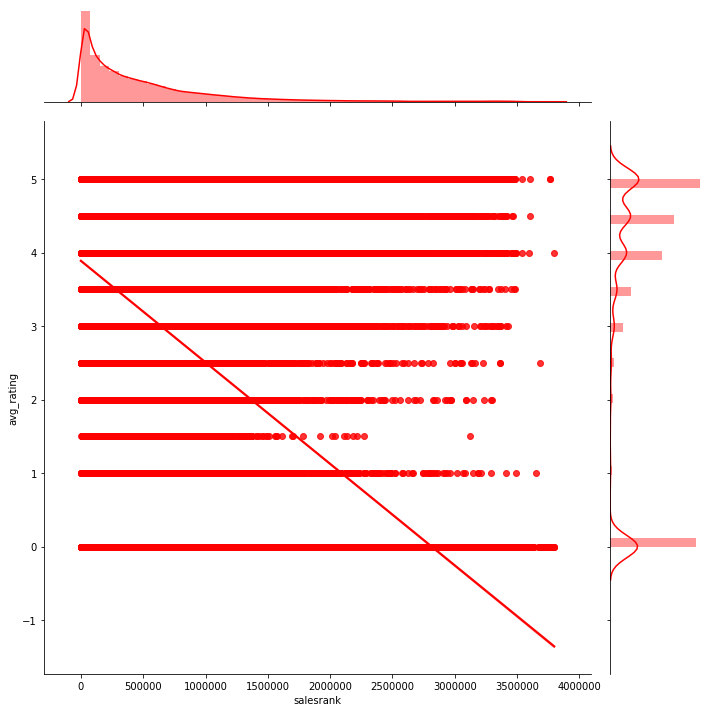

In [33]:
# jointplot for 'salesrank' and 'avg_rating'
sns.jointplot(x=df_reviews.salesrank, y=df_reviews.avg_rating, kind='reg', color='r', height=10)

> From the above table and plot we can see that there is a strong correlation between 'salesrank', 'avg_rating', 'total_reviews' and 'downloads'. Items which have a high 'avg_rating' also have a high 'salesrank'. If a product has low 'avg_rating' but high 'salesrank', this aspect needs to be investigated.

---



## Category Bloat
    
Consider the product group named 'Books'. Each product in this group is associated with categories. Naturally, with categorization, there are tradeoffs between how broad or specific the categories must be.

Q. Is there redundancy in the categorization? How can it be identified/removed?

In [34]:
# check out category at index location 0
df_reviews.categories.iloc[0]

['   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]']

In [35]:
# check out category at index location 10
df_reviews.categories.iloc[10]

['   |Books[283155]|Subjects[1000]|Health, Mind & Body[10]|Alternative Medicine[4696]|General[4701]',
 '   |Books[283155]|Subjects[1000]|Medicine[13996]|Alternative & Holistic[14038]|General[14046]',
 '   |Books[283155]|Subjects[1000]|Professional & Technical[173507]|Medical[173514]|Alternative Medicine[227583]|General[227584]',
 '   |Books[283155]|Specialty Stores[504360]|jp-unknown2[1061350]']

In [36]:
df_reviews.categories.iloc[100]

['   |Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Thrillers[10484]|General[10485]',
 '   |Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Thrillers[10484]|Spy Stories & Tales of Intrigue[10493]',
 '   |Books[283155]|Subjects[1000]|Mystery & Thrillers[18]|Thrillers[10484]|Suspense[10495]',
 '   |Books[283155]|Formats[504358]|Books on CD[69724]|Literature & Fiction[1038382]|General[69728]',
 '   |Books[283155]|Subjects[1000]|Literature & Fiction[17]|Genre Fiction[10134]|Political[171129]']

> From above we see that there are multiple categories that are repeated in the same pattern. To find out if we can reduce the redundancy, find out the distribution of the sub-categories within the category list. There may be some sub-categories that figure in only a few books. By finding if there are such categories, we can reduce category bloat.

Q. Is is possible to reduce the number of categories drastically (say to 10% of existing categories) by sacrificing relatively few category entries (say close to 10%)?

In [0]:
# categorize books
book_review_df = df_reviews[df_reviews.group == ' Book']

all_cat_list = []
total_cat_list = 0

for item in book_review_df.categories:
    for cat_list in item:
        total_cat_list = total_cat_list + 1
        for i in (cat_list[4:].strip().split('|')):
            all_cat_list.append(i)

In [38]:
# total number of books
len(book_review_df)

393185

In [39]:
all_cat_list[:10]

['Books[283155]',
 'Subjects[1000]',
 'Religion & Spirituality[22]',
 'Christianity[12290]',
 'Clergy[12360]',
 'Preaching[12368]',
 'Books[283155]',
 'Subjects[1000]',
 'Religion & Spirituality[22]',
 'Christianity[12290]']

In [40]:
len(all_cat_list)

7888637

In [41]:
# total categories across books
total_cat_list

1439870

In [42]:
# unique categories across books
len(set(all_cat_list))

14922

There are total of 393,185 books; 1,439,870 grouping of categories across books and 14,922 unique categories.

In [0]:
# cast all book categories into a dataframe
cat_df = pd.DataFrame(all_cat_list)

In [0]:
# name the column as 'Category'
cat_df.columns = ['Category']

In [0]:
# group the dataframe by 'Category', get 'Category' count, sort the values and reset the index
cat_count_df = pd.DataFrame(cat_df.groupby('Category').size().sort_values()).reset_index()

In [0]:
# name the column as 'Category' and 'Count'
cat_count_df.columns = ['Category','Count']

In [47]:
cat_count_df.Count.sum()

7888637

In [48]:
# check the 'Category' where 'Count' is less than or equal to 1
cat_count_df[cat_count_df.Count<=1].head(10)

,Category,Count
0,"von Konigslow, Andrea Wayne[1044084]",1
1,Renaissance (c.1450-1600)[490124],1
2,Eastern European[4278],1
3,Audio CD[287468],1
4,Suites[36675],1
5,"Leonard, Paul[15540]",1
6,Musicals & Performing Arts[508526],1
7,"Atwood, Margaret[1064970]",1
8,"Hassam, Childe[67955]",1
9,Muslim[1804],1


In [49]:
# get total number of 'Category' where 'Count' is less than or equal to 1
len(cat_count_df[cat_count_df.Count<=1])

1104

> We see that there are 1104 out of 14,922 occur only once in the categorization. Hence by looking at this distribution it is possible to reduce the number of categorizations without reducing the overall specificity.

---

## Algorithm thinking

Q. How would build the product categorization from scratch, using similar/co-purchased information?

> We can use the 'similar' column attribute from the dataframe which provides ASINs of co-purchased products (people who buy X also buy Y).

---

## Product thinking

Q. Is it a good idea to show users the categorization hierarchy for items?

> It depends on the item and the level of search the customer is looking for. For example, someone who is going to buy any phone as long as it is cheap would not be helped by a hierarchial categorization. Heirarchial categorization is useful when someone is looking for a specific product or its closest alternatives.

Q. Is it a good idea to show users similar/co-purchased items?

> It usually is. There are certain types of items that people typically purchase together and showing them together acts as a reminder that the customer needs to get the other item as well. Common example, phones and memory cards.

Q. Is it a good idea to show users reviews and ratings for items?

> In most cases, yes it is. However, there may be certain drawbacks of this approach. Using the ratings allows one to manipulate the perception of the product quality. Also, showing reviews / ratings means that badly rated products / non-rated products would not get as much as air-time as other products. They may not be sold as much as it should have been.